In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

spy_data = pd.read_csv("spy_max.csv")
spy_data = spy_data.iloc[::-1].reset_index(drop=True)
spy_data = spy_data.drop(columns=['Date'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(spy_data.drop(columns=['Close/Last']))
scaled_labels = scaler.fit_transform(spy_data[['Close/Last']]).flatten()

In [37]:
def create_sequence(data, labels, seq_length, output_length):
    X = []
    y = []
    for i in range(len(data) - seq_length - output_length + 1):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length:i + seq_length + output_length])
    return np.array(X), np.array(y)

seq_len = 10
output_len = 1  

X, y = create_sequence(scaled_features, scaled_labels, seq_len, output_len)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=False,
                   input_shape=(seq_len, X.shape[2])))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16)))
    model.add(Dense(units=output_len))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10, 
    directory='keras_tuner_dir',
    project_name='lstm_hyperparameter_tuning'
)

Reloading Tuner from keras_tuner_dir/lstm_hyperparameter_tuning/tuner0.json


In [38]:
test_size = int(0.2 * len(X))
X_train_full, X_test = X[:-test_size], X[-test_size:]
y_train_full, y_test = y[:-test_size], y[-test_size:]

val_size = int(0.2 * len(X_train_full))
X_train, X_val = X_train_full[:-val_size], X_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

tuner.search(X_train, y_train, epochs=50, 
             validation_data=(X_val, y_val), 
             callbacks=[EarlyStopping(patience=3)])

best_hps = tuner.get_best_hyperparameters()[0]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
rmse_values = []

for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
    model = tuner.hypermodel.build(best_hps)
    
    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
    
    model.fit(X_train_fold, y_train_fold, 
              validation_data=(X_val_fold, y_val_fold), 
              epochs=50, 
              callbacks=[EarlyStopping(patience=3)])
    
    val_loss = model.evaluate(X_val_fold, y_val_fold)
    rmse_values.append(np.sqrt(val_loss))  


final_model = tuner.hypermodel.build(best_hps)
final_model.fit(
    X_train_full, 
    y_train_full, 
    epochs=50,
    batch_size=32,
    validation_split=0.2,  
    callbacks=[EarlyStopping(patience=3)]
)

test_loss = final_model.evaluate(X_test, y_test)
test_rmse = np.sqrt(test_loss)
print(test_loss, test_rmse)

Epoch 1/50


/Users/edserrano/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8662e-04 - val_loss: 8.7236e-05
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3558e-04 - val_loss: 8.1512e-05
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8830e-05 - val_loss: 2.8038e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9788e-05 - val_loss: 1.3670e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2645e-05 - val_loss: 4.9732e-05
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0318e-05 - val_loss: 9.1280e-05
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1878e-05 - val_loss: 4.6992e-05
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8455e-05 - val_loss: 1.2143e-04
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0403e-05 - val_loss: 4.9569e-05
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3315e-05 - val_loss: 5.2172e-05
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1834e-05
Epoch 1/50
21/21 ━━━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


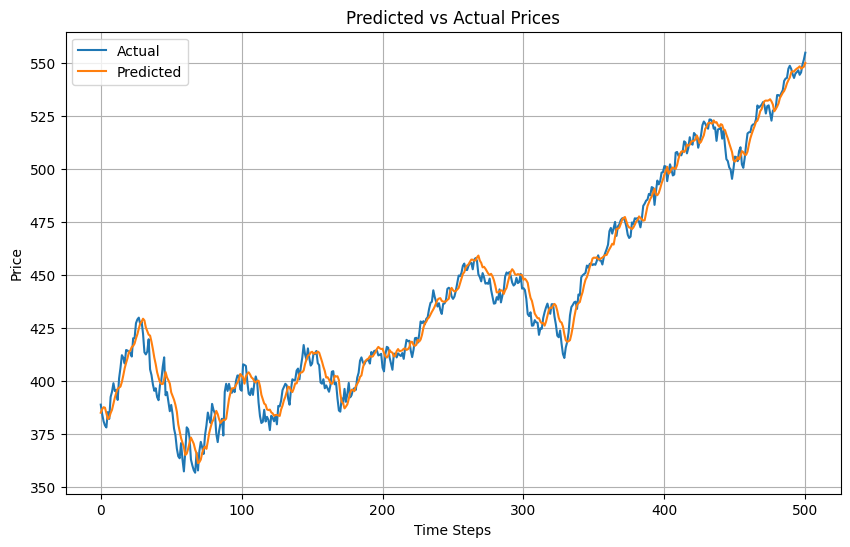

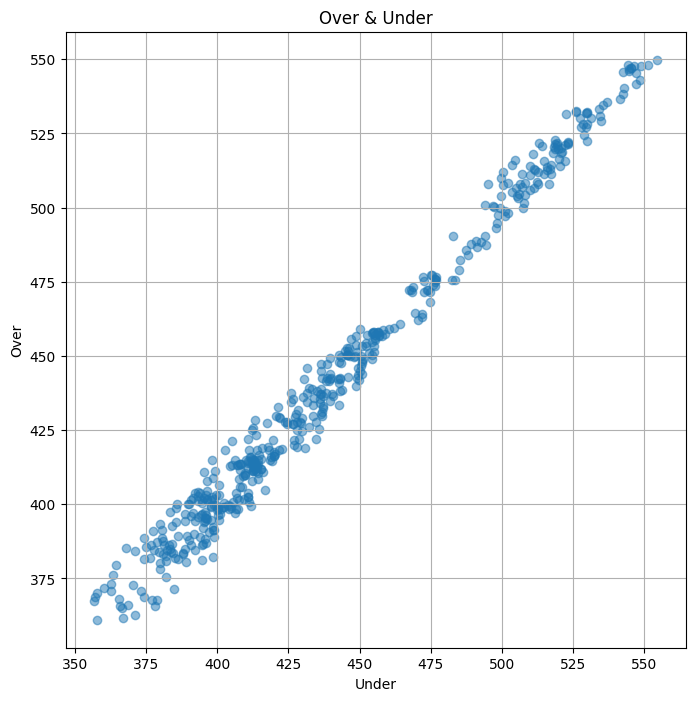

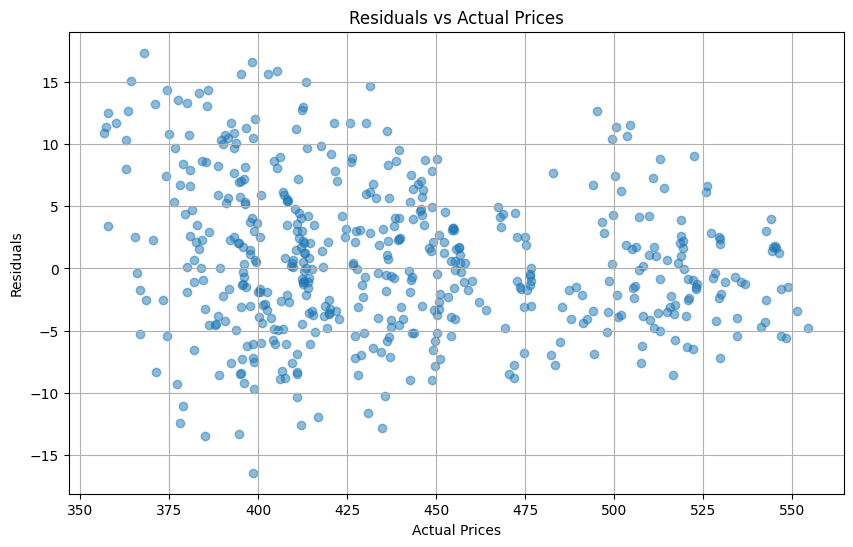

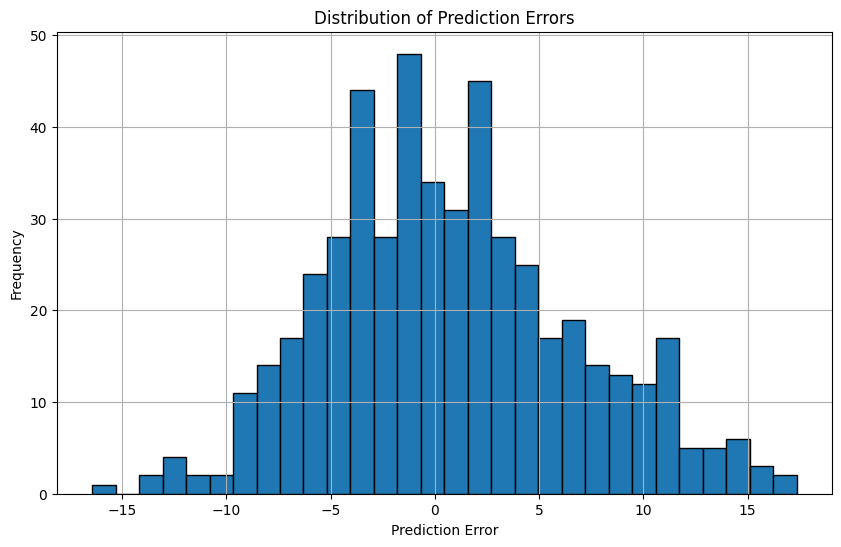

In [39]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
predictions = final_model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten() 

residuals = predictions - y_test_actual  

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, predictions, alpha=0.5)
plt.title('Over & Under')
plt.xlabel('Under')
plt.ylabel('Over')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, residuals, alpha=0.5)
plt.title('Residuals vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()